### Preparing Data

Generating 100 datapoints from the distribution $N(\left( \begin{array}{c} 2 \\ 2 \end{array}\right),\left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right))$.  

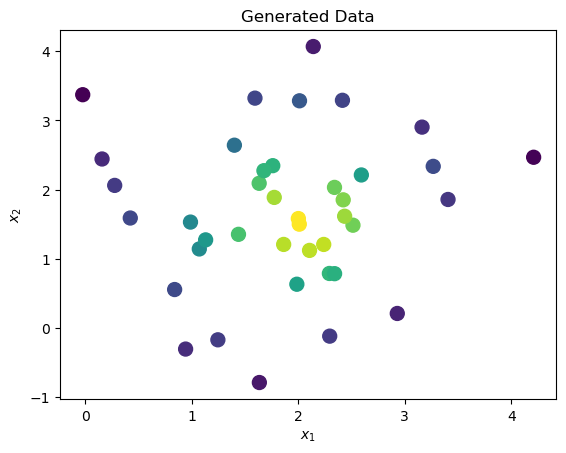

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Dataset = []
for _ in range(0,40):
    Dataset.append(list(np.random.default_rng().normal(2, 1, 2)))

x1 = [p[0] for p in Dataset]
x2 = [p[1] for p in Dataset]
x1x2 = np.vstack([x1,x2])
z = gaussian_kde(x1x2)(x1x2)
plt.scatter(x1, x2, c=z, s=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Generated Data")
plt.show()

### Generating the likelihood function

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_5197/3316284806.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


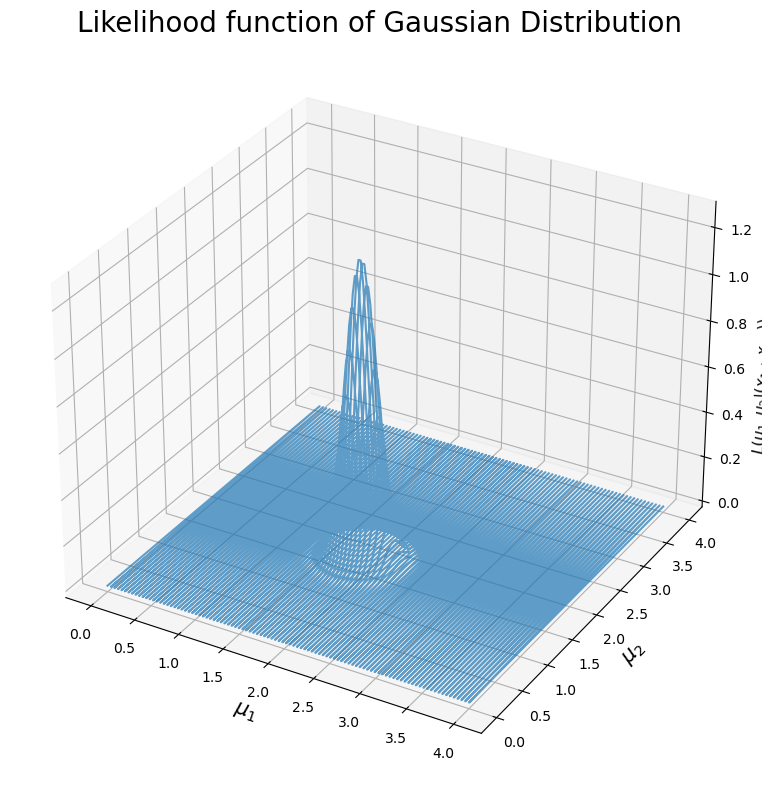

In [2]:
from StandardGaussianLikeli_Dian import Likelihood_Gaussian

Likeli = Likelihood_Gaussian(Dim=2, Dataset=Dataset)
Grid = np.linspace(0, 4, 100)
x = []
y = []
z = []
r = len(Grid)
for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]
fig = plt.figure(figsize=(8, 8), facecolor="white")
Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7)
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$L(\mu_1, \mu_2| {(x_{1,i}, x_{2,i})})_{i \in \{1,..,40\}}$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)
fig.tight_layout()
fig.show()

### Testing the Metropolis-Hasting MCMC algorithm with the likelihood function generated above

In [9]:
from typing import Callable, List
import time

def PredictAndTest(
    MHMC,
    rho: Callable,
    theta0,
    qProb: Callable,
    qSamp: Callable,
    testFreq: int,
    epoch: int,
    thetaTrue=[],
    Output_all=False,
    runningTime=False,
    seed=123
) -> List[float]:

    """

    Predicting the value of the parameter, that maximize the target distribution, and comparing the prediction value of the parameter and the true value of the parameter with a fixed frequency.
    
    Arguments
    ----------
    theta0: the initial value of the parameter
    qProb: probability of the proposal distribution of the parameter
    qSamp: draw the sample with the proposal distribution
    testFreq: test Frequency
    epoch: run the MCMC for n epoch
    thetaTrue: the true value of the parameter
    runningTime: deciding whether to calculate the running time of the algorithm
    
    Returns
    -------
    theta_n: the prediction of the value of the parameter, that maximize the target distribution
    
    
    """

    MHMCF = MHMC(rho=rho, seed=seed)
    if runningTime:
        start_time = time.time()
    if testFreq>epoch:
        print("Test frequency should smaller or equal to the training epoch.")
        return theta0
    I = epoch//testFreq
    if thetaTrue:
        MSELoss = [np.sqrt(np.sum(np.square(np.array(thetaTrue)-np.array(theta0))))] # The set of mean square loss of the prediction made by the MHMCMC Algorithm
        Epoch = [i*testFreq for i in range(0, I+1)]
    thetan = theta0
    for _ in range(0, I):
        thetan = MHMCF.predict(theta0=thetan, qProb=qProb, qSamp=qSamp, epoch=testFreq, Output_all=Output_all)
        if Output_all:
            thetanExp = [sum(thetan[:][i])/testFreq for i in range(0,len(thetan[0]))]
            if thetaTrue:
                MSELoss.append(np.sqrt(np.sum(np.square(np.array(thetaTrue)-np.array(thetanExp)))))
            thetan = thetan[-1]
        else:
            if thetaTrue:
                MSELoss.append(np.sqrt(np.sum(np.square(np.array(thetaTrue)-np.array(thetan)))))
    if epoch%testFreq!=0:
        thetan = MHMCF.predict(theta0=thetan, qProb=qProb, qSamp=qSamp, epoch=epoch%testFreq, Output_all=Output_all)
        if Output_all:
            thetanExp = [sum(thetan[:][i])/(epoch%testFreq) for i in range(0,len(thetan[0]))]
            if thetaTrue:
                MSELoss.append(np.sqrt(np.sum(np.square(np.array(thetaTrue)-np.array(thetanExp)))))
                Epoch.append(Epoch[-1]+epoch%testFreq)
            thetan = thetanExp
        else:
            if thetaTrue:
                MSELoss.append(np.sqrt(np.sum(np.square(np.array(thetaTrue)-np.array(thetan)))))
                Epoch.append(Epoch[-1]+epoch%testFreq)
    if runningTime:
        runTime = (time.time()-start_time)
        runTimeS = (runTime)%60
        runTime -= runTimeS
        runTimeM = ((runTime)%3600)//60
        runTime -= runTimeM
        runTimeH = runTime//3600
        print(f"The total running time = ({runTimeH:.0f} hours, {runTimeM:.0f} minutes, {runTimeS:.2f} seconds)")
    if thetaTrue:
        plt.rcParams["figure.figsize"] = (12,8)
        plt.plot(Epoch, MSELoss, label="Mean_Square_Loss")
        plt.legend(fontsize=20)
        plt.xlabel("epoch", fontsize=20)
        plt.ylabel("loss value", fontsize=20)
        plt.tight_layout()
        plt.show()
    return thetan


Approximating the maximumlikelihood value of the parameter with the last output value of the MHMCMC Algorithm
The total running time = (0 hours, 0 minutes, 2.80 seconds)


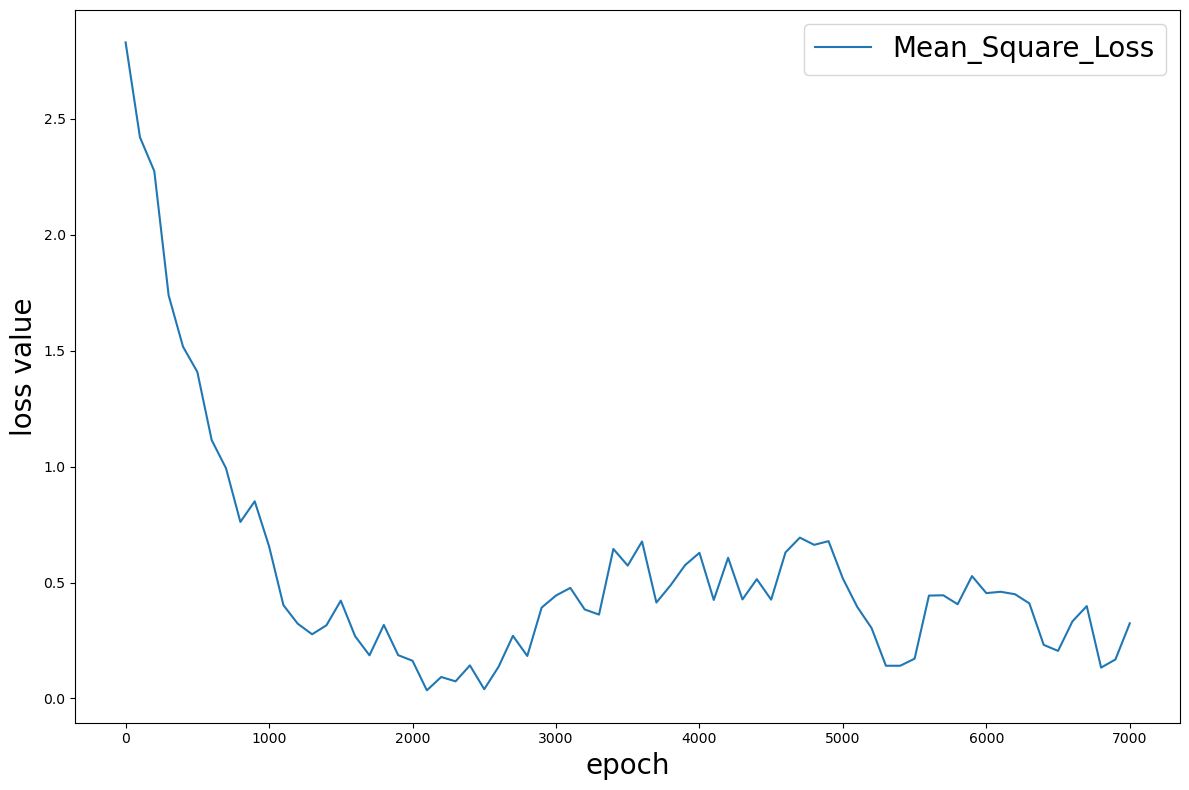

------------------------------
Approximating the maximumlikelihood value of the parameter with the expected value of the output value of the MHMCMC Algorithm
The total running time = (0 hours, 0 minutes, 2.92 seconds)


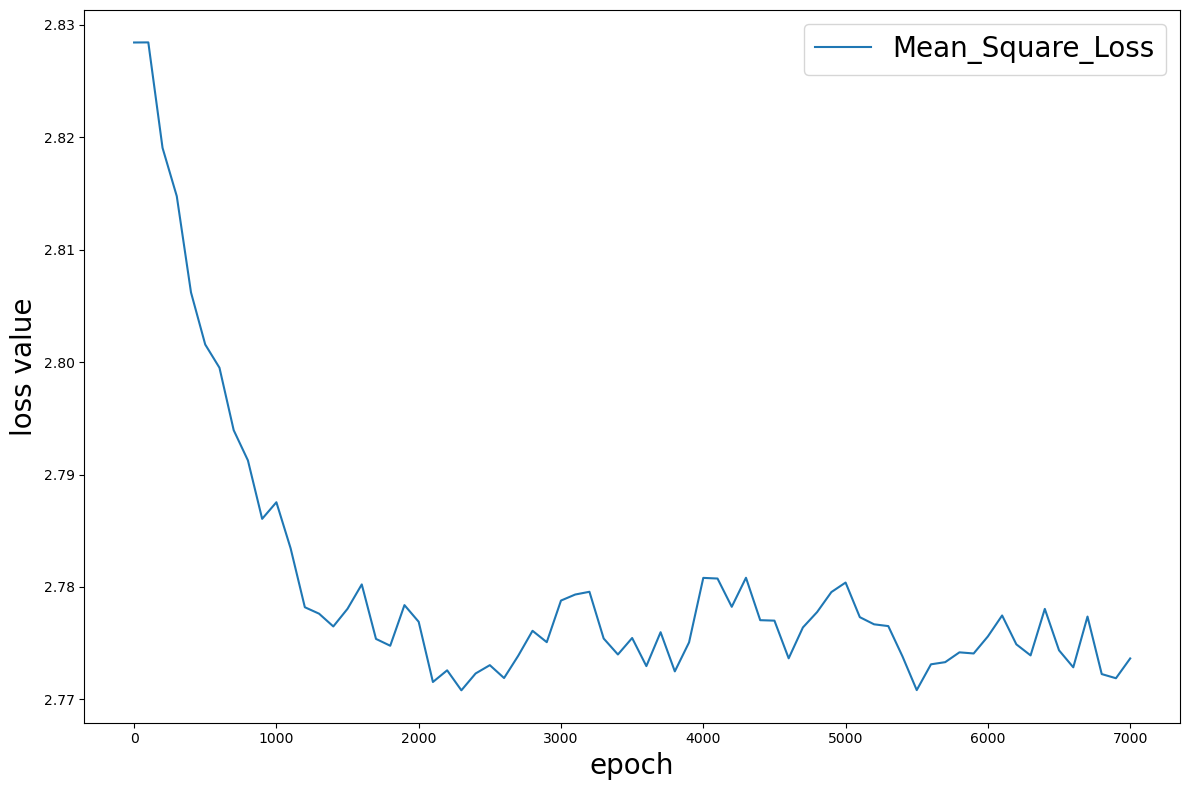

[2.0990173542408423, 1.7932607556169045]

In [10]:
from ProposalDistributions_Dian import GausianProposalDistributiob
from MHMC_Dian import MHMC

q = GausianProposalDistributiob(sd=0.014, Dim=2)
print("Approximating the maximumlikelihood value of the parameter with the last output value of the MHMCMC Algorithm")
PredictAndTest(
    MHMC=MHMC,
    rho=Likeli.L,
    qProb=q.qProb,
    qSamp=q.qSample,
    theta0=[0,0],
    testFreq=100,
    epoch=7000,
    thetaTrue=[2,2],
    runningTime=True,
    Output_all=False
)
print("------------------------------")
print("Approximating the maximumlikelihood value of the parameter with the expected value of the output value of the MHMCMC Algorithm")
PredictAndTest(
    MHMC=MHMC,
    rho=Likeli.L,
    qProb=q.qProb,
    qSamp=q.qSample,
    theta0=[0,0],
    testFreq=100,
    epoch=7000,
    thetaTrue=[2,2],
    runningTime=True,
    Output_all=True
)